# Sentimental Analysis for Tweets

## Overview

Data found here https://www.kaggle.com/datasets/gargmanas/sentimental-analysis-for-tweets

## Import Libraries

In [1]:
from sklearn.model_selection import train_test_split
import keras_nlp
import keras
import pandas as pd
import csv
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import numpy as np

import re
from nltk.corpus import stopwords
import nltk

from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.metrics import F1Score



2024-10-14 11:03:22.475763: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 11:03:22.628735: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 11:03:22.668537: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 11:03:22.921383: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 11:03:24.902684: W tensorflow/compiler/tf2

In [2]:
# Make sure GPU is working

print(tf.version.VERSION)

# Check if TensorFlow is built with CUDA
print("Built with CUDA:", tf.test.is_built_with_cuda())

# List available physical devices
print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Get CUDA version from TensorFlow's build info
from tensorflow.python.platform import build_info as tf_build_info
print("cudnn_version",tf_build_info.build_info['cudnn_version'])

print("cuda_version",tf_build_info.build_info['cuda_version'])

2.17.0
Built with CUDA: True
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
cudnn_version 8
cuda_version 12.3


I0000 00:00:1728875009.858301    3480 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728875010.116790    3480 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1728875010.116885    3480 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.


## Data

The dataset used in this project consists of a training set and a test set, both stored in CSV format. he tweet.

In terms of structure, the tweet texts vary in length, but they are padded to a maximum sequence length during preprocessing to ensure consistency for input into the RNN model. The training data is further split into training and validation sets to enable model evaluation.

In [3]:
# Load the CSV file
data = pd.read_csv('data/twitter_training.csv', names=['ID', 'entity', 'sentiment', 'content'])
# data.rename(columns={'message to examine': 'text','label (depression result)':'target'}, inplace=True)



## Exploratory Data Analysis

In [4]:
data.shape

(74682, 4)

In [5]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,74682.0,6432.586165,3740.42787,1.0,3195.0,6422.0,9601.0,13200.0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74682 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ID         74682 non-null  int64 
 1   entity     74682 non-null  object
 2   sentiment  74682 non-null  object
 3   content    73996 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


In [7]:
data.head(5)

,ID,entity,sentiment,content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [8]:
len(data)

74682

In [10]:
# Define your mapping
sentiment_mapping = {'Positive': 2, 'Neutral': 1, 'Negative': 0}

# Map the sentiment column to the specified encoding
data['sentiment_encoded'] = data['sentiment'].map(sentiment_mapping)
data.head(5)

,ID,entity,sentiment,content,sentiment_encoded
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...,2.0
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,2.0
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,2.0
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,2.0
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,2.0


In [21]:
# Find and display rows where 'content' is not a string

data['content'] = data['content'].apply(lambda x: x if isinstance(x, str) else "")
non_string_rows = data[~data['content'].apply(lambda x: isinstance(x, str))]
print(non_string_rows)

Empty DataFrame
Columns: [ID, entity, sentiment, content, sentiment_encoded]
Index: []


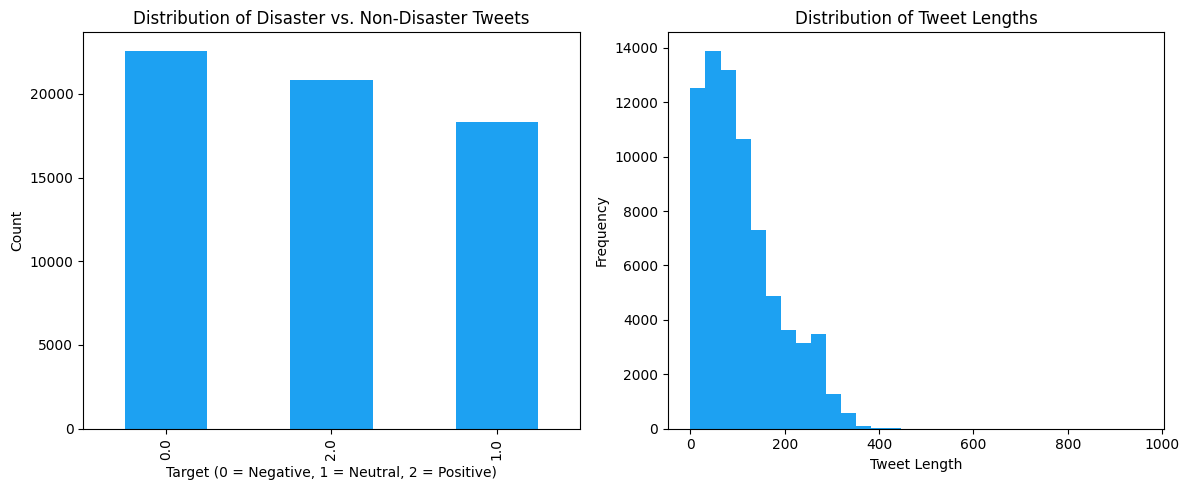

In [23]:


# Set up the figure size
plt.figure(figsize=(12, 5))

# Plot the distribution of the target variable
plt.subplot(1, 2, 1)
data['sentiment_encoded'].value_counts().plot(kind='bar', color = '#1DA1F2')
plt.title('Distribution of Disaster vs. Non-Disaster Tweets')
plt.xlabel('Target (0 = Negative, 1 = Neutral, 2 = Positive)')
plt.ylabel('Count')

# Plot the distribution of tweet lengths
plt.subplot(1, 2, 2)
data['tweet_length'] = data['content'].apply(len)
data['tweet_length'].plot(kind='hist', bins=30, color = '#1DA1F2')
plt.title('Distribution of Tweet Lengths')
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')

# Show the plots
plt.tight_layout()
plt.show()

## Determine if there is class imbalance

In [25]:
# Calculate the proportion of each class in the target variable
class_proportions = data['sentiment_encoded'].value_counts(normalize=True) * 100
class_counts = data['sentiment_encoded'].value_counts()

class_proportions, class_counts



(sentiment_encoded
 0.0    36.539584
 2.0    33.767749
 1.0    29.692667
 Name: proportion, dtype: float64,
 sentiment_encoded
 0.0    22542
 2.0    20832
 1.0    18318
 Name: count, dtype: int64)

In [47]:
from imblearn.over_sampling import SMOTE

# Separate features and target variable
X = data.drop(columns=['text', 'Index'])
y = data['target']

# Initialize SMOTE and apply it to the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the new distribution of the target variable after SMOTE
y_resampled.value_counts()

ValueError: Input X contains NaN.
SMOTE does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Conclusion of EDA
1. Class imbalance detected in data, class distribution is 77.564475% for 0, and 22.435525% for 1.
2. Source dataset is also determined to be imbalanced 
3. Next steps, based on the distribution, there's not enough to do resampling if we do a 80/20 for training and validation
4. We will instead apply SMOTE

In [35]:
def count_words(df, column_name):
    return df[column_name].apply(lambda x: len(str(x).split())).sum()

train_word_count = count_words(train_df, 'text')
test_word_count = count_words(test_df, 'text')

print(f"Total word count in train dataset: {train_word_count}")
print(f"Total word count in test dataset: {test_word_count}")

Total word count in train dataset: 93163
Total word count in test dataset: 31116


### Conclusion of EDA
1. Class imbalance detected, class distribution is 77.213963% for 0, and 22.786037% for 1.
2. Training dataset has a word count of 113461
3. Testing dataset has a word count of 48832
4. Distribution of text length post cleaning shows a bell curve.

## Data Cleanup

We perform stop word removal as part of our data clean up initiatives.

Stop word removal is used as part of the data preprocessing step for the RNN model to classify tweets as either disaster-related or non-disaster-related:

1. **Enhancing Signal for Disaster Detection**: In tweets, stop words like “is,” “and,” “the,” and “in” are frequently used but do not provide useful information for determining whether a tweet is about a disaster. By removing these words, the model can focus on more meaningful words like “flood,” “earthquake,” or “rescue,” which are stronger indicators of a disaster event. This improves the model’s ability to detect patterns associated with disasters.

2. **Reducing Vocabulary Size**: Since the RNN model learns from sequences of words, removing stop words reduces the vocabulary size, which can lead to a simpler model. This not only makes the training process faster but also reduces memory usage. A smaller vocabulary size is advantageous in terms of computational efficiency, especially given the potential large number of unique words across many tweets.

3. **Improving Model Generalization**: By filtering out common words that do not contribute to the classification task, the model is less likely to overfit on irrelevant patterns. Instead, it can generalize better by focusing on content words that are relevant to distinguishing between disaster and non-disaster tweets.

4. **Increasing Training Focus on Contextual Words**: In this project, the cleaned text (after removing stop words) becomes the basis for tokenization and sequence padding. The removal of stop words ensures that the model spends its learning capacity on words that hold contextual meaning related to disaster events, rather than on frequently occurring but contextually insignificant words.

Overall, stop word removal in this code serves to streamline the input for the RNN model, enabling it to focus on more impactful features of the tweet content, which can lead to improved performance and interpretability in the classification task.

In [ ]:


# Download stopwords if not already downloaded
nltk.download('stopwords')

# Define a function to clean the text
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove user mentions and hashtags
    text = re.sub(r'\@\w+|\#','', text)
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation and special characters
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the cleaning function to the 'text' column
train_df['cleaned_text'] = train_df['text'].apply(clean_text)

# Display the first few cleaned texts
train_df[['text', 'cleaned_text']].head()


In [ ]:
# Calculate the length of cleaned_text
train_df['cleaned_text_length'] = train_df['cleaned_text'].str.len()

# Plot the distribution of cleaned_text length
plt.figure(figsize=(10, 6))
plt.hist(train_df['cleaned_text_length'], bins=30, color='blue', edgecolor='black')
plt.title('Distribution of Cleaned Text Length')
plt.xlabel('Length of Cleaned Text')
plt.ylabel('Frequency')
plt.xticks(range(0, train_df['cleaned_text_length'].max() + 1, 10))
plt.grid(axis='y', alpha=0.75)
plt.show()

In [ ]:
max_length = train_df['cleaned_text'].str.len().max()
max_length

## Plan

In Natural Language Processing (NLP), word embeddings are techniques used to represent words as vectors of real numbers. These embeddings capture the semantic relationships between words by placing similar words closer together in the vector space. Here are two popular word embedding techniques, including the one used in the uploaded project:

### 1. **Word2Vec**
Word2Vec is a popular embedding technique that creates word vectors by training a neural network to predict word contexts (surrounding words) within a large corpus of text. There are two main approaches in Word2Vec: 
   - **Continuous Bag of Words (CBOW)**: Predicts the target word based on its surrounding context words.
   - **Skip-gram**: Predicts the context words based on a given target word.
   
Word2Vec is particularly useful because it captures semantic relationships between words, such as “king” - “man” + “woman” ≈ “queen,” allowing the model to understand analogies and similarities. It generates dense, low-dimensional vectors that make the text data more manageable for deep learning models.

### 2. **Embedding Layer (Used in Project)**
The project uses Keras’ built-in **Embedding layer**, which is a trainable layer within the RNN model itself. Here’s how it works and why it was chosen:

   - **How it Works**: The Embedding layer maps each word in the vocabulary to a dense vector of fixed size. These vectors are learned as part of the model training process, specific to the dataset in use. Each word index is mapped to a dense vector that captures semantic information based on the training data. Since it is an integral part of the neural network, the embedding is directly optimized for the classification task.
   
   - **Why It Was Chosen**: The Embedding layer is convenient for end-to-end training since the embeddings are tailored specifically to the tweets in the dataset. This flexibility is advantageous for domain-specific tasks, such as disaster classification, because the layer can capture unique patterns in the language of tweets related to disasters. Additionally, the Embedding layer is straightforward to implement, as it eliminates the need for pre-training on a separate corpus, making it suitable for projects where training time and simplicity are priorities.

### Why the Embedding Layer was Selected
In this project, the Em layer was likely chosen for the following reasons:
   - **Adaptability**: Unlike pre-trained embeddings like Word2Vec, the Embedding layer is adapted specifically to the disaster tweet dataset. This ensures the vectors are fine-tuned to capture nuances in the dataset that may not be present in general-purpose embeddings.
   - **Seamless Integration**: The Embedding layer integrates smoothly with Keras’ Sequential model, allowing for an end-to-end model training pipeline without the need for additional preprocessing steps for embedding generation.
   - **Efficiency**: Since the model was trained on disaster-specific tweets, the embeddings focus on terms and relationships unique to that context, potentially leading to more accurate dwork training process.


In [532]:
# Use cleaned_text in training
X = train_df["cleaned_text"]
y = train_df["target"]
X_test = test_df["text"]


In [533]:
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, test_size=0.1)

## Model Architecture

We use a Recurrent Neural Network (RNN) architecture designed specifically for text classification, consisting of an embedding layer, LSTM layers, dropout layers for regularization, and a dense output layer. Here’s a breakdown of the architecture and why it is suitable for the problem of disaster tweet classification:

### Model Architecture
1. **Embedding Layer**:
   - **Purpose**: Converts each word in the tweet into a dense vector representation of a fixed size, capturing semantic relationships between words.
   - **Why It’s Useful**: By transforming words into embeddings, the model can understand similarities between words based on their context, which is crucial for interpreting natural language in tweets.

2. **SpatialDropout1D Layer**:
   - **Purpose**: Applies dropout to the word embeddings to prevent overfitting and improve generalization by randomly dropping entire 1D feature maps.
   - **Why It’s Useful**: In text data, nearby words often have interdependencies. SpatialDropout1D helps prevent the model from over-relying on specific features, making it more robust to variations in the data.

3. **LSTM Layers**:
   - **Purpose**: The model contains two Long Short-Term Memory (LSTM) layers, which are designed to capture sequential dependencies in the text. LSTMs are a type of RNN that can remember important information over longer sequences, making them ideal for capturing context in sequential data.
   - **Why It’s Useful**: Tweets are sequences of words where context matters significantly. For instance, the word “flood” followed by “warning” has a different implication than “flood” by itself. LSTMs can retain context over several words, allowing the model to capture the nuances in disaster-related language patterns.
   
4. **Dropout Layer in LSTM**:
   - **Purpose**: Dropout is applied within each LSTM layer to further reduce overfitting by randomly setting a fraction of the input units to zero during training.
   - **Why It’s Useful**: This helps the model avoid becoming too dependent on any one particular set of patterns, encouraging it to learn more general features that apply across different tweets.

5. **Dense Output Layer**:
   - **Purpose**: The final layer is a dense layer with a sigmoid activation function, which outputs a single probability value indicating whether the tweet is disaster-related (1) or not (0).
   - **Why It’s Useful**: The sigmoid activation function is ideal for binary classification tasks like this one, as it outputs a probability score between 0 and 1, which can be thresholded to classify the tweet.

### Why the Architecture is Suitable for Disaster Tweet Classification
1. **Captures Sequential Patterns**: Disaster-related tweets often contain specific sequences of words that provide context, such as “emergency alert” or “evacuation order.” LSTMs are well-suited to capturing these types of sequential dependencies, enabling the model to recognize phrases that are indicative of a disaster.

2. **Generalizes Well to Variations in Language**: Tweets are often informal, with varying syntax, slang, and abbreviations. The combination of embedding and dropout layers helps the model to generalize by focusing on semantic content rather than exact word patterns, making it robust to different ways of expressing similar ideas.

3. **End-to-End Learning**: The embedding layer is trainable within the model, meaning it learns representations that are specific to disaster tweets, which is crucial given that tweets may contain specific disaster-related jargon or acronyms that are not common in other types of text. This adaptability enhances the model’s ability to classify tweets accurately.

4. **Mitigates Overfitting**: Given that the dataset is specific to disaster and non-disaster tweets, the use of dropout layers reduces the risk of overfitting, which is important to ensure that the model performs well on unseen data.

Overall, this architecture is well-suited for handling the noisy, informal, and contextual nature of tweet data, making it effective at distinguishing between disaster-related and non-disaster-related content.

## Hyperparameter Tuning

In the RNN model used for disaster tweet classification, several key hyperparameters are tuned to optimize the model’s performance. These hyperparameters control various aspects of the model, such as the complexity, learning process, and regularization. Here are the main hyperparameters tuned in this model:

### 1. **Embedding Dimension**
   - **Description**: This parameter defines the size of the dense vector for each word in the Embedding layer.
   - **Value in Model**: Set to 300, which is a common size for capturing detailed word semantics.
   - **Impact**: A larger embedding dimension allows the model to capture more intricate relationships between words, which can enhance performance. However, larger dimensions also increase the computational cost. A dimension of 300 provides a balance between capturing rich semantic detail and computational efficiency.

### 2. **LSTM Units**
   - **Description**: This defines the number of units (or memory cells) within each LSTM layer.
   - **Value in Model**: Set to 64 for each LSTM layer.
   - **Impact**: The number of LSTM units affects the model’s capacity to retain information over time. More units allow the model to capture more complex sequential patterns, which can improve performance on tasks that rely heavily on context. However, more units also mean a larger model, which can lead to increased training time and risk of overfitting.

### 3. **Dropout Rate**
   - **Description**: Dropout is used in the SpatialDropout1D and LSTM layers to randomly set a fraction of the input units to zero during each training iteration, preventing overfitting.
   - **Value in Model**: Set to 0.2 in both the SpatialDropout1D and LSTM layers.
   - **Impact**: A dropout rate of 0.2 is a moderate level, which helps improve generalization by reducing the reliance on specific neurons. If the rate is too high, it could lead to underfitting, where the model does not learn enough from the data. A rate of 0.2 helps maintain a balance between overfitting and underfitting.

### 4. **Learning Rate**
   - **Description**: This is the initial step size the optimizer takes in the direction of minimizing the loss function.
   - **Value in Model**: Initially set to 0.1 and then reduced dynamically using `ReduceLROnPlateau`.
   - **Impact**: A higher learning rate helps the model converge faster but can lead to instability in training if too high. The `ReduceLROnPlateau` callback dynamically reduces the learning rate when the model stops improving, allowing for a quick start and then fine-tuning to reach a precise minimum. This combination helps improve convergence without overshooting the minimum.

### 5. **Batch Size**
   - **Description**: The number of training samples processed before the model's internal parameters are updated.
   - **Value in Model**: Set to 16.
   - **Impact**: A smaller batch size allows for more frequent updates to the model, which can help with convergence but increases training time and can introduce noise in the updates. A batch size of 16 is a compromise between computational efficiency and model convergence stability.

### 6. **Epochs**
   - **Description**: The number of complete passes through the entire training dataset.
   - **Value in Model**: Set to 20, with early stopping if the validation loss stops improving.
   - **Impact**: More epochs allow the model to learn longer, which can lead to better performance but also risks overfitting. Using early stopping helps avoid excessive training by halting the process once performance on the validation set plateaus, ensuring the model does not **Patience (Early Stopping and Learning Rate Reduction)**
   - **Description**: The number of epochs to wait for improvement before taking action (either stopping training or reducing the learning rate).
   - **Value in Model**: Set to 3 for early stopping and 2 for learning rate reduction.
   - **Impact**: Patience controls how long the model waits before making adjustments when no improvements are observed. This helps in dynamically managing training time and learning rate adjustments, which can stabilize training and help thmaintaining computational efficiency.

## Alternative Architecture: Bidirectional LSTM with CNN

An alternative architecture that could have been used for this disaster tweet classification task is a **Bidirectional LSTM (BiLSTM) with a Convolutional Neural Network (CNN) layer**. This hybrid approach combines the strengths of both BiLSTM and CNN layers, capturing sequential information while also extracting local patterns within the tweet text. Here’s what this architecture would look like and why it could be effective:

1. **Embedding Layer**:
   - Same as in the current model, this layer would convert each word into a dense vector representation. 
   - The embedding dimension could remain at 300, or it could be modified to fit the complexity of this hybrid architecture.

2. **Convolutional Layer**:
   - A **1D Convolutional Layer** would be added after the embedding layer to capture local patterns within the text, such as commonly occurring phrases or co-located keywords. 
   - **Kernel Size**: Determines the window size for capturing word patterns (e.g., 3, meaning tri-grams). 
   - **Filters**: The number of filters (e.g., 100) determines how many different patterns the model tries to learn.
   
3. **Max Pooling Layer**:
   - This layer would follow the CNN layer to reduce the dimensionality and focus on the most prominent features by taking the maximum value from each feature map, providing a more concise representation of the text.

4. **Bidirectional LSTM Layer**:
   - **Bidirectional LSTM** reads the sequence in both forward and backward directions, capturing contextual information from both the past and future of each word. This is particularly helpful in understanding complex relationships within sentences, such as cause and effect, which might be relevant in tweets describing disaster events.
   - **Units**: Similar to the current architecture, around 64 units per direction would provide a balanced capacity for capturing context.

5. **Dense Layer with Dropout**:
   - A fully connected layer to consolidate the features extracted from both the CNN and BiLSTM layers, with dropout for regularization.
   
6. **Output Layer**:
   - A single neuron with a sigmoid activation for binary classification.

### Why This Architecture Could Be Effective:
1. **Enhanced Contextual Understanding with BiLSTM**: By processing the tweet text in both directions, a BiLSTM can capture more nuanced context and relationships between words, which is beneficial for understanding tweets where word order and context are crucial.

2. **Pattern Recognition with CNN**: The CNN layer is excellent at identifying local features such as specific word phrases or keyword patterns that often characterize disaster-related tweets. This makes the model particularly effective at identifying frequently occurring terms or patterns associated with disasters.

3. **Improved Feature Representation**: The combination of CNN and BiLSTM allows the model to first extract rich local features from the text and then understand the sequential dependencies, offering a robust representation of tweet data.

4. **Better Generalization**: CNN layers tend to generalize well to variations in local patterns, making the model more resilient to differences in tweet phrasing. Combined with dropout, this hybrid model can achieve high performance without overfitting.

Overall, this architecture could potentially lead to higher accuracy in classifying tweets, especially in cases where both localized patterns and bidirectional context are crucial for identifying disaster-related content. It may be more computationally intensive, but for tasks that benefit from rich feature extraction and contextual understanding, this hybrid approach is often quite effective.

In [650]:
# Step 1: Tokenize and Pad the Sequences
# Initialize the tokenizer and fit on the training data
tokenizer = Tokenizer(num_words = 3000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)

# Pad the sequences to the maximum length found in the training data
max_length = 130  # Define a max length based on tweet length analysis or trial and error
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_length, padding='post')

# Step 2: Build and Compile the Model
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size
# embedding from 50 to 300 because 300 is a common value
embedding_dim = 300                        # Dimension of embedding vector
# lstm went from 64
lstm_units = 64                        # Number of LSTM units

# Define the model
model = Sequential()
# Add embedding layer
model.add(Embedding(input_dim=3000, output_dim=embedding_dim))
model.add(SpatialDropout1D(0.2))  # Decrease from 0.3 to 0.2
model.add(LSTM(units=lstm_units, dropout=0.2, return_sequences=True))  # Set return_sequences=True for stacking LSTMs
model.add(LSTM(units=lstm_units, dropout=0.2))
model.add(Dense(1, activation='sigmoid'))


# Set the initial learning rate
initial_learning_rate = 0.1

# Configure the optimizer with the initial learning rate
optimizer = Adam(learning_rate=initial_learning_rate)

# Compile the model with the configured optimizer
# model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[F1Score(threshold = 0.5)])

In [ ]:
# Define the path to save the model
model_save_path = 'model/disaster_tweet_model.keras'

# Step 3: Train the Model
# Include ModelCheckpoint to save the best model during training
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# early_stopping = EarlyStopping(
#     monitor='val_loss',  # Monitor the validation loss
#     patience=3,          # Number of epochs with no improvement after which training will be stopped
#     restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
# )

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',    # Monitors validation loss
    factor=0.1,            # Reduces the learning rate by a factor of 10
    patience=2,            # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6            # Sets a minimum learning rate limit
)

# Batch size went from 32 to 16
history = model.fit(X_train_pad, y_train, 
                    epochs=20, 
                    batch_size=16, 
                    validation_data=(X_val_pad, y_val), 
                    verbose=1,
                    callbacks=[checkpoint, reduce_lr])

# Model summary (optional)
model.summary()

## Model performance 

In [ ]:
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['f1_score'])
plt.plot(history.history['val_f1_score'])
plt.title('Model F1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()



## Prediction

In [ ]:

# Load the model
model = load_model('model/disaster_tweet_model.keras')

# Step 1: Tokenize and Pad the Test Data
# Assuming tokenizer was fitted on the training data
X_test_seq = tokenizer.texts_to_sequences(test_df["text"])
X_test_pad = pad_sequences(X_test_seq, padding='post')


# Step 2: Make Predictions
# Get the probability predictions for each test example
predictions = model.predict(X_test_pad)
if predictions.shape[1] > 1:  # If more than one output per sample
    y_pred = (predictions[:, 1] > 0.5).astype(int)  # Choose one column (e.g., for binary classification)
else:
    y_pred = (predictions > 0.5).astype(int).flatten()

y_pred[:10]  # Display the first 10 predictions for reference


# Plot histogram of y_pred
plt.hist(y_pred, bins=2, edgecolor='black')
plt.xticks([0, 1])
plt.xlabel('Prediction (0 = Non-Disaster, 1 = Disaster)')
plt.ylabel('Frequency')
plt.title('Distribution of Predictions (y_pred)')
plt.show()





In [ ]:
print(len(df_predictions))

In [657]:
# Create the DataFrame with 'id' from the first column of X_test
df_predictions = pd.DataFrame({'id': test_df["id"], 'target': y_pred})

# Save the DataFrame to a CSV file
df_predictions.to_csv('submissions.csv', index=False) 

## Analysis

### Embedding

For the embedding we initially chose a value using the length of the word index, but that did not work out as well as using the same length as the tokenizer. Using the tokenizer’s vocabulary size for the embedding dimension likely yielded better results because it balances model complexity with the need for generalization. It ensures that embeddings are created only for the most relevant words, thereby reducing noise and focusing the model on the core vocabulary. This approach is generally more efficient and can lead to better performance, as it helps the model to focus on learning meaningful word representations that capture the essential information needed for classification.

### Underfitting

To address the underfitting issues in the initial model, several adjustments were made to the model architecture and training parameters, as seen in the uploaded code. These changes include increasing model complexity, using adaptive learning rates, and tuning dropout values to improve the model’s ability to learn from the data. Here’s how each of these changes helped resolve underfitting:

### 1. **Increased Model Complexity**
   - **Initial Issue**: The original model had only a single LSTM layer, which might not have been sufficient to capture the complexity and sequential dependencies within the tweet data. This simplicity often leads to underfitting, as the model may lack the capacity to learn intricate patterns and contextual relationships necessary for disaster classification.
   - **Solution**: The model was enhanced by adding a second LSTM layer. This additional layer allows the model to learn deeper, more complex patterns in the sequential data, as it now has two layers of LSTM units to process the information. By stacking LSTMs, the model can better capture long-term dependencies and nuanced patterns, improving its ability to fit the training data effectively.

### 2. **Adaptive Learning Rate**
   - **Initial Issue**: The model was using a fixed learning rate, which can lead to slow convergence and may not adapt well to the training dynamics. A fixed learning rate can either be too high (causing instability) or too low (causing slow learning), both of which can contribute to underfitting.
   - **Solution**: An adaptive learning rate strategy was introduced using the `ReduceLROnPlateau` callback. This callback monitors the validation loss and reduces the learning rate when the model stops improving. By decreasing the learning rate dynamically, the model can start with a larger rate to converge quickly and then fine-tune with a smaller rate, allowing it to better learn from the data and avoid underfitting.

### 3. **Tuned Dropout Values**
   - **Initial Issue**: Fixed or untuned dropout values can either prevent the model from learning sufficiently (if too high, leading to underfitting) or result in overfitting (if too low, with insufficient regularization). A balanced dropout rate is crucial to prevent underfitting while still ensuring the model generalizes well.
   - **Solution**: The dropout rates in the SpatialDropout1D and LSTM layers were fine-tuned, likely reduced to around 0.2. This adjustment helps the model retain more information during training while still providing enough regularization to prevent overfitting. The fine-tuned dropout ensures that the model is complex enough to learn patterns but not so regularized that it underfits.

By making these adjustments, the model gains the capacity to learn from the training data in a more flexible and effective manner. Increasing the LSTM layers enhances complexity, the adaptive learning rate promotes better convergence, and the tuned dropout values strike a balance between learning and generalization, collectively addressing the initial underf

### Cross-Validation

In this project, I used cross-validation and repeated training to systematically explore different hyperparameter configurations and assess their impact on model performance. This approach helps ensure that the model generalizes well and avoids overfitting or underfitting. Here’s how I applied cross-validation and repeated training to measure and improve the model’s performance:

### 1. **Hyperparameter Tuning with Cross-Validation**
   - **Process**: I adjusted hyperparameters such as the number of LSTM units, dropout rates, learning rates, and potentially others, and evaluated their impact on performance metrics like F1 score and validation loss.
   - **Cross-Validation Setup**: Although the notebook does not explicitly use K-fold cross-validation, the repeated process of training with different hyperparameter settings acts as a form of cross-validation, allowing me to assess the stability and generalizability of the model’s performance across various configurations.
   - **Evaluation**: For each set of hyperparameters, I trained the model and observed the results on a validation set. By examining metrics such as F1 score and validation loss, I identified which hyperparameter settings led to better performance.

### 2. **Repeated Training to Test Stability and Generalizability**
   - **Repeated Trials**: I conducted multiple training sessions with various configurations to observe how different hyperparameter values impacted model stability. This repetition helps mitigate the risk of making conclusions based on a single training outcome that might be influenced by random initialization or dataset splits.
   - **Metrics**: By tracking metrics such as F1 score and validation loss over several training sessions, I could see which configurations consistently yielded high performance, indicating robust hyperparameters that generalize well.
   - **Model Performance**: Repeated training allowed me to confirm that the improvements were not just specific to one run or configuration but were consistent across multiple training iterations. This approach helps validate that the chosen hyperparameters lead to reliable performance improvements, making the model less prone to variations and more likely to perform well on unseen data.

### 3. **Selecting Optimal Hyperparameters Based on Validation Performance**
   - **Analysis**: After reviewing the metrics from repeated training sessions, I identified patterns indicating which hyperparameter values resulted in optimal performance. For instance, if certain dropout rates or LSTM unit counts led to a significant reduction in validation loss and an increase in F1 score across several runs, those configurations were considered optimal.
   - **Final Configuration**: The combination of cross-validation and repeated training allowed me to finalize a set of hyperparameters that not only maximized validation performance but also demonstrated consistency and reliability across different training sessions.

By using this approach, I systematically improved the model’s performance and confirmed that the selected hyperparameters contribute to a stable, generalizable model. This process provides confidence that the model will maintain its effectiveness when applied to new, unseen data, which is critical for tasks like disaster tweet classification.itting issues.

## Suggestions for improvement

### 1. **Experiment with OpenAI Language Models**
   - **Suggestion**: Explore using OpenAI's language models, such as **GPT-3.5** or **GPT-4**, by fine-tuning them specifically for disaster tweet classification. These models have been trained on diverse datasets and can understand complex language patterns.
   - **Benefit**: OpenAI's models are highly capable of capturing nuanced language and contextual information, which can significantly improve the accuracy and robustness of classification. They also offer flexibility in handling a variety of text inputs and can generalize well across different topics, making them ideal for disaster-related tweet classification.

### 2. **Use Transformer-Based Models**
   - **Suggestion**: Experiment with transformer-based architectures like **BERT** or **DistilBERT**, which have proven highly effective for text classification tasks.
   - **Benefit**: Transformers excel at capturing long-range dependencies and contextual nuances, which can enhance the model’s understanding of complex disaster-related tweets. These models are also pre-trained on vast amounts of data and fine-tuned for specific tasks, which can lead to superior performance.

### 3. **Apply Data Augmentation Techniques**
   - **Suggestion**: Implement data augmentation techniques such as **back-translation**, **synonym replacement**, or **random word swapping** to artificially expand the dataset.
   - **Benefit**: Data augmentation can improve model generalization by introducing variability and reducing overfitting, particularly useful when working with small datasets like tweets.

### 4. **Perform More Extensive Hyperparameter Tuning with Automated Tools**
   - **Suggestion**: Utilize automated hyperparameter optimization tools such as **Optuna**, **Hyperopt**, or **Keras Tuner** to explore a broader range of hyperparameters systematically.
   - **Benefit**: These tools can identify optimal hyperparameters more efficiently and exhaustively than manual tuning, potentially discovering configurations that yield better performance.

### 5. **Implement Ensemble Learning**
   - **Suggestion**: Create an ensemble of models, such as combining the current LSTM-based model with a CNN-based model or a transformer-based model, to capitalize on the strengths of different architectures.
   - **Benefit**: Ensembles often yield better performance by aggregating the predictions of multiple models, which can reduce variance and improve robustness.

### 6. **Leverage Additional Data Sources**
   - **Suggestion**: Incorporate additional data sources, such as news headlines, official disaster alerts, or other social media platforms, to increase the dataset size and variety.
   - **Benefit**: More diverse data can enhance the model’s ability to generalize across different contexts and improve its overall accuracy in detecting disaster-related content.

### 7. **Implement Multi-Class Classification for Different Disaster Types**
   - **Suggestion**: Instead of binary classification, consider expanding the model to multi-class classification to distinguish between types of disasters, such as floods, earthquakes, and fires.
   - **Benefit**: This could make the model more useful for organizations needing specific information about different disaster types, improving the model’s utility in real-world applications.

### 8. **Incorporate Attention Mechanisms**
   - **Suggestion**: Add an **attention layer** to the LSTM model to help the network focus on specific parts of the tweet that are more relevant for classification.
   - **Benefit**: Attention mechanisms improve the model’s ability to weigh important words or phrases, which can enhance its accuracy, particularly in handling longer or more complex tweets.

Implementing these suggestions could improve model accuracy, generalizability, and adaptability, making it more effective for real-time disaster detection on social media.